In [49]:
globals().clear()


from __future__ import (absolute_import, division, print_function, unicode_literals)
from builtins import * 
from io import BytesIO, TextIOWrapper
from zipfile import ZipFile
import urllib.request
import csv
from shapely.geometry import Point
import geopandas as gpd

import time
import numpy as np
import zarr
from shapely.geometry import Polygon, Point
import pandas as pd
import geopandas as gpd
import s3fs
import os


os.chdir('C:/Users/lbeatty/Documents/Lauren_MIP_Contribution/')


In [50]:
def rect(i, w, s, e, n):
    x = [w[i], e[i], e[i], w[i], w[i]]
    y = [s[i], s[i], n[i], n[i], s[i]]
    return x, y

def poly(sr):
    ret = []
    w = sr["W"][:]
    s = sr["S"][:]
    e = sr["E"][:]
    n = sr["N"][:]
    for i in range(52411):
        x, y = rect(i, w, s, e, n)
        ret.append(Polygon([[x[0],y[0]],[x[1],y[1]],[x[2],y[2]],
                            [x[3],y[3]],[x[4],y[4]]]))
    return ret

def run_sr(emis, model, emis_units="tons/year"):
    start = time.time()
    url = 's3://inmap-model/isrm_v1.2.1.zarr/'
    fs = s3fs.S3FileSystem(anon=True, client_kwargs=dict(region_name='us-east-2'))
    sr = zarr.open(s3fs.S3Map(url, s3=fs, check=False), mode="r")
#     the following line is used when we access the SR matrix from local files
#     sr = zarr.open("isrm_v1.2.1.zarr", mode="r")

    # build the geometry
    p = poly(sr)
    print("Making polygons as geometry.")

    # took the emis geopandas dataframe
    df = pd.DataFrame({'Location': range(52411)})
    gdf = gpd.GeoDataFrame(df, geometry=p)

    # join the emis dataframe into the grid dataframe
    emis.crs = "+proj=longlat"
    gdf.crs = "+proj=lcc +lat_1=33.000000 +lat_2=45.000000 +lat_0=40.000000 +lon_0=-97.000000 +x_0=0 +y_0=0 +a=6370997.000000 +b=6370997.000000 +to_meter=1"
    emis = emis.to_crs(gdf.crs)
    join_right_df = gdf.sjoin(emis, how="right")
    print("Finished joining the dataframes.")
    
    index = join_right_df.Location.tolist()

    ppl = np.unique(join_right_df.Location.tolist())

    num = range(0,len(ppl))

    dictionary = dict(zip(ppl, num))
        
    SOA = sr['SOA'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("SOA data is allocated.")
    pNO3 = sr['pNO3'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pNO3 data is allocated.")
    pNH4 = sr['pNH4'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pNH4 data is allocated.")
    pSO4 = sr['pSO4'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pSO4 data is allocated.")
    PM25 = sr['PrimaryPM25'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("PrimaryPM25 data is allocated.")
    
    SOA_data, pNO3_data, pNH4_data, pSO4_data, PM25_data = 0.0, 0.0, 0.0, 0.0, 0.0
    for i in range(len(index)):
        SOA_data += SOA[0, dictionary[index[i]], :]*emis.VOC[i]
        pNO3_data += pNO3[0, dictionary[index[i]], :]*emis.NOx[i]
        pNH4_data += pNH4[0, dictionary[index[i]], :]*emis.NH3[i]
        pSO4_data += pSO4[0, dictionary[index[i]], :]*emis.SOx[i]
        PM25_data += PM25[0, dictionary[index[i]], :]*emis.PM2_5[i]
    data = SOA_data + pNO3_data + pNH4_data + pSO4_data + PM25_data

    print("Accessing the data.")
    if emis_units=="tons/year":
        fact = 28766.639

    TotalPM25 = fact * data
    TotalPop = sr['TotalPop'][0:52411]
    MortalityRate = sr['MortalityRate'][0:52411]
    deathsK = (np.exp(np.log(1.06)/10 * TotalPM25) - 1) * TotalPop * 1.0465819687408728 * MortalityRate / 100000 * 1.025229357798165
    deathsL = (np.exp(np.log(1.14)/10 * TotalPM25) - 1) * TotalPop * 1.0465819687408728 * MortalityRate / 100000 * 1.025229357798165
    
    ret = gpd.GeoDataFrame(pd.DataFrame({'SOA': fact * SOA_data,
                                         'pNO3': fact * pNO3_data,
                                         'pNH4': fact * pNH4_data,
                                         'pSO4': fact * pSO4_data,
                                         'PrimaryPM25': fact * PM25_data,
                                         'TotalPM25': TotalPM25,
                                         'deathsK': deathsK,
                                         'deathsL': deathsL}), geometry=p[0:52411])

    print("Finished (%.0f seconds)               "%(time.time()-start))
    return ret

In [51]:
scenario = '26z-short-base-50'
model = 'GenX'

years = ['2030', '2040', '2050']

for year in years:
    emis = gpd.read_file('InMap/MIP_Emissions/'+scenario+'/'+model+'/emissions_'+year+'.shp')
    emis.update(emis[['NH3', 'NOx', 'VOC', 'SOx', 'PM2_5']].mul(0.00110231))  #switch from kg to ton
    print(emis.sum())
    resultsISRM = run_sr(emis, model="isrm")
    resultsISRM.to_file(filename='InMap/MIP_InMap_Output/'+scenario+'/'+model+'/ISRM_result_'+year+'.shp')

C:\Users\lbeatty\AppData\Local\Temp\ipykernel_16148\1207553703.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(emis.sum())


Longitude    -84.1103-89.629722-71.17527800000001-82.396388...
Latitude     31.555944.88777844.47194429.767531.83213243.08...
NOx                                              634649.930432
SOx                                              149724.118303
PM2_5                                            202311.197547
VOC                                                45580.82374
NH3                                              109367.187885
dtype: object
Making polygons as geometry.
Finished joining the dataframes.
SOA data is allocated.
pNO3 data is allocated.
pNH4 data is allocated.
pSO4 data is allocated.
PrimaryPM25 data is allocated.
Accessing the data.
Finished (1312 seconds)               


C:\Users\lbeatty\AppData\Local\Temp\ipykernel_16148\1207553703.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  resultsISRM.to_file(filename='InMap/MIP_InMap_Output/'+scenario+'/'+model+'/ISRM_result_'+year+'.shp')
C:\Users\lbeatty\AppData\Local\Temp\ipykernel_16148\1207553703.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(emis.sum())


Longitude    -84.1103-89.629722-71.17527800000001-82.396388...
Latitude     31.555944.88777844.47194429.767531.83213243.08...
NOx                                              670214.870727
SOx                                              161467.234912
PM2_5                                            222163.304233
VOC                                                52348.75403
NH3                                              119246.898995
dtype: object
Making polygons as geometry.
Finished joining the dataframes.
SOA data is allocated.
pNO3 data is allocated.
pNH4 data is allocated.
pSO4 data is allocated.
PrimaryPM25 data is allocated.
Accessing the data.
Finished (1200 seconds)               


C:\Users\lbeatty\AppData\Local\Temp\ipykernel_16148\1207553703.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  resultsISRM.to_file(filename='InMap/MIP_InMap_Output/'+scenario+'/'+model+'/ISRM_result_'+year+'.shp')
C:\Users\lbeatty\AppData\Local\Temp\ipykernel_16148\1207553703.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(emis.sum())


Longitude    -84.1103-89.629722-71.17527800000001-82.396388...
Latitude     31.555944.88777844.47194429.767531.83213239.87...
NOx                                              556468.632104
SOx                                               37436.244297
PM2_5                                            232284.339119
VOC                                               58238.633652
NH3                                              123497.663265
dtype: object
Making polygons as geometry.
Finished joining the dataframes.
SOA data is allocated.
pNO3 data is allocated.
pNH4 data is allocated.
pSO4 data is allocated.
PrimaryPM25 data is allocated.
Accessing the data.
Finished (1068 seconds)               


C:\Users\lbeatty\AppData\Local\Temp\ipykernel_16148\1207553703.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  resultsISRM.to_file(filename='InMap/MIP_InMap_Output/'+scenario+'/'+model+'/ISRM_result_'+year+'.shp')


        SOA      pNO3      pNH4      pSO4  PrimaryPM25  TotalPM25  deathsK  \
0  0.000029  0.000088  0.000341  0.000033     0.000226   0.000716      0.0   
1  0.000029  0.000088  0.000341  0.000033     0.000226   0.000716      0.0   
2  0.000029  0.000088  0.000341  0.000033     0.000226   0.000716      0.0   
3  0.000029  0.000088  0.000341  0.000033     0.000226   0.000716      0.0   
4  0.000029  0.000088  0.000341  0.000033     0.000226   0.000716      0.0   

   deathsL                                           geometry  
0      0.0  POLYGON ((-2736000.000 -2088000.000, -2688000....  
1      0.0  POLYGON ((-2736000.000 -2040000.000, -2688000....  
2      0.0  POLYGON ((-2736000.000 -1992000.000, -2688000....  
3      0.0  POLYGON ((-2736000.000 -1944000.000, -2688000....  
4      0.0  POLYGON ((-2736000.000 -1896000.000, -2688000....  


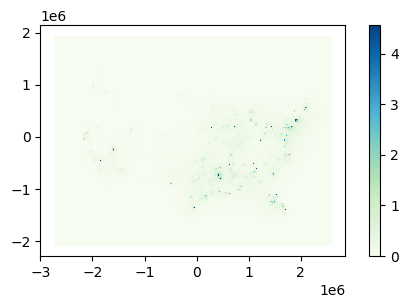

In [48]:
print(resultsISRM.head())

deaths = pd.DataFrame.from_dict({
    "Model": ["ISRM"],
    "Krewski Deaths": [resultsISRM.deathsK.sum()],
    "LePeule Deaths": [resultsISRM.deathsL.sum()],
})

cut = resultsISRM.TotalPM25.quantile(0.985)
resultsISRM.plot(column=resultsISRM.TotalPM25, cmap="GnBu", legend=True, 
                 vmin=0, vmax=cut, figsize=(6, 3))

ISRM_dataframe = pd.DataFrame(resultsISRM)